# Fine Tuning the PaddleOCR Model


In [1]:
# !python -m pip install paddlepaddle-gpu==2.6.0 -i https://mirror.baidu.com/pypi/simple
# !pip install paddleocr==2.7.3

Looking in indexes: https://mirror.baidu.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.8/749.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.0/780.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 M

In [ ]:
import os

# from paddleocr import PaddleOCR

from PIL import Image, ImageDraw

import numpy as np
import pandas as pd

import ast
import json

In [4]:
# !unzip /content/train_data.zip

## Data Processing and Formatting for Fine-tuning


In [ ]:
df = pd.read_csv('data.csv')

df['bbox'] = df['bbox'].apply(ast.literal_eval)
df['transcription'] = df['transcription'].apply(ast.literal_eval)

def bbox_to_coordinates(bbox_list):
  temp = []
  for bbox in bbox_list:
    x = bbox['x']*bbox["original_width"]/100
    y = bbox['y']*bbox["original_height"]/100
    width = bbox['width']*bbox["original_width"]/100
    height = bbox['height']*bbox["original_height"]/100
    temp.append([[int(round(x)), int(round(y))],[int(round(x + width)), int(round(y))],[int(round(x + width)), int(round(y + height))], [int(round(x)), int(round(y + height))]])
  return temp

df['bbox'] = df['bbox'].apply(lambda x: bbox_to_coordinates(x))

output_file_path = "det_annotations.txt"

with open(output_file_path, "w") as file:
    for index, row in df.iterrows():
        annotation_info = []
        for i in range(len(row['bbox'])):
          annotation_info.append({"transcription": row["transcription"][i], "points": row["bbox"][i]})
        file.write(f"{row['ocr']}\t{json.dumps(annotation_info)}\n")
print("Text file created successfully.")

/content
Text file created successfully.


In [ ]:
def get_bb(box):
  x = [int(i[0]) for i in box]
  y = [int(i[1]) for i in box]
  return min(x),min(y),max(x),max(y)


csv_file = 'data.csv'

image_folder = '/content/PaddleOCR/train_data/Images'

output_folder = '/content/cropped_images/'
os.makedirs(output_folder, exist_ok=True)

df = pd.read_csv(csv_file)
df['bbox'] = df['bbox'].apply(ast.literal_eval)
df['transcription'] = df['transcription'].apply(ast.literal_eval)

def bbox_to_coordinates(bbox_list):
  temp = []
  for bbox in bbox_list:
    x = bbox['x']*bbox["original_width"]/100
    y = bbox['y']*bbox["original_height"]/100
    width = bbox['width']*bbox["original_width"]/100
    height = bbox['height']*bbox["original_height"]/100
    temp.append([[int(round(x)), int(round(y))],[int(round(x + width)), int(round(y))],[int(round(x + width)), int(round(y + height))], [int(round(x)), int(round(y + height))]])
  return temp

df['bbox'] = df['bbox'].apply(lambda x: bbox_to_coordinates(x))

new_df = pd.DataFrame(columns = ['image_name', 'transcription'])

for index, row in df.iterrows():
    image_name = row['ocr']
    bboxes = row['bbox']
    transcription = row['transcription']

    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path)

    for i, bbox in enumerate(bboxes):
        bbox = tuple(bbox)
        cropped_image = image.crop(get_bb(bbox))
        cropped_image_path = os.path.join(output_folder, f'{image_name.split(".")[0]}_{i}.png')
        cropped_image.save(cropped_image_path)
        text=transcription[i]
        new_df = pd.concat([new_df,pd.DataFrame({'image_name':[f'{image_name.split(".")[0]}_{i}.png'] , 'transcription': [text]})], ignore_index = True)
        # new_df = new_df.append(new_data)

new_df.to_csv('rec_annotations.csv', index=False)

In [ ]:
def gen_rec_label(input_path, out_label):
    with open(out_label, 'w') as out_file:
        with open(input_path, 'r') as f:
            for line in f.readlines():
                tmp = line.strip('\n').replace(" ", "").split(',')
                img_path, label = tmp[0], tmp[1]
                label = label.replace("\"", "")
                out_file.write(img_path + '\t' + label + '\n')

gen_rec_label('/content/rec_annotations.csv','/content/rec_annotations.txt')

In [ ]:
%cd /content/PaddleOCR/ppocr/utils

!python gen_label.py --mode="rec" --input_path="/content/rec_annotations.csv" --output_label="/content/rec_annotations.txt"

%cd /content/PaddleOCR/

Generate rec label


## Cloning the PaddleOCR GitHub Repository

In [1]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git
%cd PaddleOCR
!pip install -r requirements.txt

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 48649, done.
remote: Counting objects: 100% (1003/1003), done.
remote: Compressing objects: 100% (754/754), done.
remote: Total 48649 (delta 329), reused 754 (delta 237), pack-reused 47646
Receiving objects: 100% (48649/48649), 346.68 MiB | 27.97 MiB/s, done.
Resolving deltas: 100% (33859/33859), done.
Updating files: 100% (1923/1923), done.
/content/PaddleOCR


In [ ]:
# %cd PaddleOCR

!wget -P ./train_data/  https://paddleocr.bj.bcebos.com/dataset/train_icdar2015_label.txt
!wget -P ./train_data/  https://paddleocr.bj.bcebos.com/dataset/test_icdar2015_label.txt

/content/PaddleOCR
--2024-04-26 23:57:24--  https://paddleocr.bj.bcebos.com/dataset/train_icdar2015_label.txt
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.46.61, 2409:8c04:1001:1203:0:ff:b0bb:4f27
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.46.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063118 (1.0M) [text/plain]
Saving to: ‘./train_data/train_icdar2015_label.txt’

train_icdar2015_lab 100%[===================>]   1.01M   248KB/s    in 5.3s    

2024-04-26 23:57:31 (197 KB/s) - ‘./train_data/train_icdar2015_label.txt’ saved [1063118/1063118]

--2024-04-26 23:57:31--  https://paddleocr.bj.bcebos.com/dataset/test_icdar2015_label.txt
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.46.61, 2409:8c04:1001:1203:0:ff:b0bb:4f27
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.46.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468453 (4

# Fine tuning the Detection model

Downloading the PP-OCRv3_det pre-trained model to fine tune it with our dataset

In [5]:
!wget -P ./pretrain_models/ https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_distill_train.tar
!tar -xf /content/PaddleOCR/pretrain_models/en_PP-OCRv3_det_distill_train.tar
!rm -rf /content/PaddleOCR/pretrain_models/en_PP-OCRv3_det_distill_train.tar

--2024-04-29 18:35:15--  https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_distill_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.46.61, 2409:8c04:1001:1203:0:ff:b0bb:4f27
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.46.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139335680 (133M) [application/x-tar]
Saving to: ‘./pretrain_models/en_PP-OCRv3_det_distill_train.tar’

en_PP-OCRv3_det_dis 100%[===================>] 132.88M  14.1MB/s    in 26s     

2024-04-29 18:35:43 (5.12 MB/s) - ‘./pretrain_models/en_PP-OCRv3_det_distill_train.tar’ saved [139335680/139335680]



Running train.py using our config file to train the model.

In [7]:
!python3 tools/train.py -c ./configs/det/ch_PP-OCRv3/ch_PP-OCRv3_det_student.yml

[2024/04/29 18:38:32] ppocr INFO: Architecture : 
[2024/04/29 18:38:32] ppocr INFO:     Backbone : 
[2024/04/29 18:38:32] ppocr INFO:         disable_se : True
[2024/04/29 18:38:32] ppocr INFO:         model_name : large
[2024/04/29 18:38:32] ppocr INFO:         name : MobileNetV3
[2024/04/29 18:38:32] ppocr INFO:         scale : 0.5
[2024/04/29 18:38:32] ppocr INFO:     Head : 
[2024/04/29 18:38:32] ppocr INFO:         k : 50
[2024/04/29 18:38:32] ppocr INFO:         name : DBHead
[2024/04/29 18:38:32] ppocr INFO:     Neck : 
[2024/04/29 18:38:32] ppocr INFO:         name : RSEFPN
[2024/04/29 18:38:32] ppocr INFO:         out_channels : 96
[2024/04/29 18:38:32] ppocr INFO:         shortcut : True
[2024/04/29 18:38:32] ppocr INFO:     Transform : None
[2024/04/29 18:38:32] ppocr INFO:     algorithm : DB
[2024/04/29 18:38:32] ppocr INFO:     model_type : det
[2024/04/29 18:38:32] ppocr INFO: Eval : 
[2024/04/29 18:38:32] ppocr INFO:     dataset : 
[2024/04/29 18:38:32] ppocr INFO:      

In [2]:
!python3 tools/eval.py -c ./configs/det/ch_PP-OCRv3/ch_PP-OCRv3_det_student.yml

W0426 04:51:03.419543 23273 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
[2024/04/26 04:51:04] ppocr INFO: resume from /content/PaddleOCR/outputs/PP-OCRv3_det_distill/latest
[2024/04/26 05:03:52] ppocr INFO: metric eval ***************
[2024/04/26 05:03:52] ppocr INFO: precision:0.9250337990085624
[2024/04/26 05:03:52] ppocr INFO: recall:0.84153653025357
[2024/04/26 05:03:52] ppocr INFO: hmean:0.884801676878426
[2024/04/26 05:03:52] ppocr INFO: fps:8.921687172647406


In [ ]:
!python3 tools/export_model.py -c ./configs/det/ch_PP-OCRv3/ch_PP-OCRv3_det_student.yml

W0426 23:38:57.472551 21374 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.2, Runtime API Version: 11.8
W0426 23:38:57.473731 21374 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
[2024/04/26 23:38:57] ppocr INFO: load pretrain successful from ./output/ch_PP-OCR_V3_det/best_model/model
I0426 23:39:00.706614 21374 program_interpreter.cc:212] New Executor is Running.
[2024/04/26 23:39:00] ppocr INFO: inference model is saved to ./outputs/det_inference/inference


# Fine Tuning the Recognition Model

In [ ]:
!wget -P ./pretrain_models/ https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_train.tar
!tar -xf ./pretrain_models/en_PP-OCRv3_rec_train.tar && rm -rf ./pretrain_models/en_PP-OCRv3_rec_train.tar

--2024-04-26 21:04:23--  https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.46.61, 2409:8c04:1001:1203:0:ff:b0bb:4f27
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.46.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204093440 (195M) [application/x-tar]
Saving to: ‘./pretrain_models/en_PP-OCRv3_rec_train.tar’

en_PP-OCRv3_rec_tra 100%[===================>] 194.64M  13.3MB/s    in 31s     

2024-04-26 21:04:56 (6.22 MB/s) - ‘./pretrain_models/en_PP-OCRv3_rec_train.tar’ saved [204093440/204093440]



In [1]:
!python3 tools/train.py -c /content/PaddleOCR/configs/rec/PP-OCRv3/en_PP-OCRv3_rec.yml -o Global.pretrained_model=/content/PaddleOCR/pretrain_models/en_PP-OCRv3_rec_train/best_accuracy

In [ ]:
!python3 tools/export_model.py -c /content/PaddleOCR/configs/rec/PP-OCRv3/en_PP-OCRv3_rec.yml -o Global.pretrained_model=/content/PaddleOCR/pretrain_models/en_PP-OCRv3_rec_train/best_accuracy Global.save_inference_dir=/content/PaddleOCR/outputs/rec_inference

In [ ]:
from paddleocr import PaddleOCR

det_model_path = '/content/PaddleOCR/outputs/det_inference'
rec_model_path = '/content/PaddleOCR/outputs/rec_inference'

ocr = PaddleOCR(det_model_dir=det_model_path, rec_model_dir=rec_model_path, lang='en')

results = ocr.ocr('test.jpg')

download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:15<00:00, 671kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:11<00:00, 193kiB/s]

[2024/04/26 23:41:09] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/content/PaddleOCR/outputs/det_inference', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='/usr/local

In [ ]:
def paddle_to_easy(result):
  results = []
  for r in result[0]:
    temp = []
    temp.append(r[0])
    temp.append(r[1][0])
    temp.append(r[1][1])
    results.append(temp)
  return results

def preprocess_text_objects(results):
  filtered = results
  transformed = []
  merged = []

  for obj in filtered:
    center_x = sum([i[0] for i in obj[0]])//4
    center_y = sum([i[1] for i in obj[0]])//4
    height = max([abs(obj[0][0][1]-i[1]) for i in obj[0]])
    width = max([abs(obj[0][0][0]-i[0]) for i in obj[0]])
    transformed.append([[center_x,center_y,height,width],obj[1]])

  return transformed

def draw_boxes(image, results):
    draw = ImageDraw.Draw(image)
    for result in results:
        x_center, y_center, height, width = result[0]
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2
        draw.rectangle([x_min, y_min, x_max, y_max], outline=(0, 255, 0), width=2)
    return image

In [ ]:
results

[[[339.0, 90.0, 18.0, 217.0], 'DELTA STATE UNIVERSITY'],
 [[367.0, 108.0, 13.0, 127.0], 'ABRAKA,NIGERIA'],
 [[368.0, 121.0, 10.0, 88.0], 'THE REGISTRAR'],
 [[126.0, 137.0, 10.0, 53.0], 'REGISTRAR'],
 [[118.0, 164.0, 10.0, 38.0], 'Your Ref.'],
 [[183.0, 174.0, 13.0, 95.0], 'DELSU/REG/E&R T 50'],
 [[381.0, 176.0, 8.0, 20.0], 'Date'],
 [[426.0, 170.0, 12.0, 59.0], 'April 15. 2021'],
 [[117.0, 182.0, 10.0, 33.0], 'Our Ref.'],
 [[313.0, 219.0, 14.0, 117.0], 'ACADEMIC TRANSCRIPT'],
 [[147.0, 242.0, 11.0, 91.0], 'NAME OF STUDENT:'],
 [[282.0, 240.0, 13.0, 129.0], 'APPAH. WEST YIENDOIGHE'],
 [[143.0, 262.0, 13.0, 82.0], 'FACULTY: Science'],
 [[430.0, 255.0, 12.0, 129.0], 'DEPT: Mathematics & Comp. Sci'],
 [[182.0, 282.0, 13.0, 162.0], 'COURSE OF STUDY: Computer Science'],
 [[390.0, 277.0, 11.0, 47.0], 'SEX: Male'],
 [[169.0, 302.0, 13.0, 138.0], 'PLACE OF BIRTH: Pont Harcourt'],
 [[439.0, 296.0, 11.0, 145.0], 'DATE OF B1RTH: February 4. 1990'],
 [[162.0, 323.0, 11.0, 118.0], 'STATE OF ORIGIN: 

img_80_d1.png


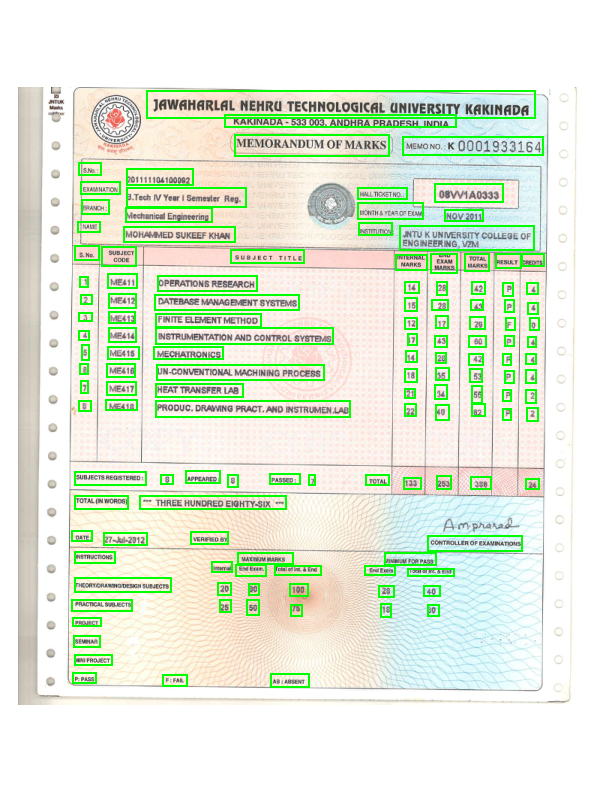

In [ ]:
image = Image.open("test.jpg")

draw_boxes(image,result)